#ColabFold v1.5.5: AlphaFold2 w/ MMseqs2 BATCH

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="256" align="right" style="height:256px">

Easy to use AlphaFold2 protein structure [(Jumper et al. 2021)](https://www.nature.com/articles/s41586-021-03819-2) and complex [(Evans et al. 2021)](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1) prediction using multiple sequence alignments generated through MMseqs2. For details, refer to our manuscript:

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

**Usage**

`input_dir` directory with only fasta files or MSAs stored in Google Drive. MSAs need to be A3M formatted and have an `.a3m` extention. For MSAs MMseqs2 will not be called.

`result_dir` results will be written to the result directory in Google Drive

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/batch/AlphaFold2_batch.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/batch/AlphaFold2_batch.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/batch/AlphaFold2_batch.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/batch/AlphaFold2_batch.ipynb)

<strong>For more details, see <a href="#Instructions">bottom</a> of the notebook and checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold). </strong>

-----------

### News
- <b><font color='green'>2023/07/31: The ColabFold MSA server is back to normal. It was using older DB (UniRef30 2202/PDB70 220313) from 27th ~8:30 AM CEST to 31st ~11:10 AM CEST.</font></b>
- <b><font color='green'>2023/06/12: New databases! UniRef30 updated to 2023_02 and PDB to 230517. We now use PDB100 instead of PDB70 (see notes in the [main](https://colabfold.com) notebook).</font></b>
- <b><font color='green'>2023/06/12: We introduced a new default pairing strategy: Previously, for multimer predictions with more than 2 chains, we only pair if all sequences taxonomically match ("complete" pairing). The new default "greedy" strategy pairs any taxonomically matching subsets.</font></b>

In [1]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')
from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

Mounted at /content/drive


In [2]:
#@title Input protein sequence, then hit `Runtime` -> `Run all`

input_dir = '/content/drive/MyDrive/input_fasta' #@param {type:"string"}
result_dir = '/content/drive/MyDrive/result' #@param {type:"string"}

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
msa_mode = "MMseqs2 (UniRef only)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
num_models = 1 #@param [1,2,3,4,5] {type:"raw"}
num_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
stop_at_score = 100 #@param {type:"string"}
#@markdown - early stop computing models once score > threshold (avg. plddt for "structures" and ptmscore for "complexes")
use_custom_msa = False
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
use_amber = num_relax > 0
relax_max_iterations = 200 #@param [0,200,2000] {type:"raw"}
use_templates = False #@param {type:"boolean"}
do_not_overwrite_results = True #@param {type:"boolean"}
zip_results = True #@param {type:"boolean"}

In [3]:
#@title Install dependencies
%%bash -s $use_amber $use_templates $python_version

set -e

USE_AMBER=$1
USE_TEMPLATES=$2
PYTHON_VERSION=$3

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  if [ -n "${TPU_NAME}" ]; then
    pip install -q --no-warn-conflicts -U dm-haiku==0.0.10 jax==0.3.25
  fi
  ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold
  ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold
  touch COLABFOLD_READY
fi

# Download params (~1min)
python -m colabfold.download

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    conda config --set auto_update_conda false
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python="${PYTHON_VERSION}" 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=8.2.0 python="${PYTHON_VERSION}" pdbfixer 2>&1 1>/dev/null
  touch AMBER_READY
fi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.8/251.8 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.0 MB/s eta 0:00:00


In [3]:
#@title Run Prediction

import sys

from colabfold.batch import get_queries, run
from colabfold.download import default_data_dir
from colabfold.utils import setup_logging
from pathlib import Path

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

setup_logging(Path(result_dir).joinpath("log.txt"))

queries, is_complex = get_queries(input_dir)
run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    num_relax=num_relax,
    relax_max_iterations=relax_max_iterations,
    msa_mode=msa_mode,
    model_type="auto",
    num_models=num_models,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=default_data_dir,
    keep_existing_results=do_not_overwrite_results,
    rank_by="auto",
    pair_mode="unpaired+paired",
    stop_at_score=stop_at_score,
    zip_results=zip_results,
    user_agent="colabfold/google-colab-batch",
)

2025-07-27 20:17:59,776 More than one sequence in /content/drive/MyDrive/input_fasta/input.fasta, ignoring all but the first sequence
2025-07-27 20:18:06,458 Running on GPU
2025-07-27 20:18:06,750 Found 4 citations for tools or databases
2025-07-27 20:18:06,750 Query 1/15: GH10_sample_1 (length 237)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:18:07,146 Sleeping for 5s. Reason: PENDING


RUNNING:   3%|▎         | 5/150 [elapsed: 00:05 remaining: 02:47]

2025-07-27 20:18:12,521 Sleeping for 5s. Reason: RUNNING


RUNNING:   7%|▋         | 10/150 [elapsed: 00:11 remaining: 02:34]

2025-07-27 20:18:17,891 Sleeping for 8s. Reason: RUNNING


RUNNING:  12%|█▏        | 18/150 [elapsed: 00:19 remaining: 02:21]

2025-07-27 20:18:26,245 Sleeping for 8s. Reason: RUNNING


RUNNING:  17%|█▋        | 26/150 [elapsed: 00:27 remaining: 02:11]

2025-07-27 20:18:34,614 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:38 remaining: 00:00]


2025-07-27 20:19:03,005 Padding length to 245
2025-07-27 20:20:14,644 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=29.4 pTM=0.185
2025-07-27 20:20:51,842 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=30.2 pTM=0.233 tol=7.32
2025-07-27 20:20:54,240 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=30.7 pTM=0.239 tol=7.17
2025-07-27 20:20:56,653 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=31.2 pTM=0.247 tol=3.45
2025-07-27 20:20:56,654 alphafold2_ptm_model_1_seed_000 took 113.6s (3 recycles)
2025-07-27 20:20:56,729 reranking models by 'plddt' metric
2025-07-27 20:20:56,729 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=31.2 pTM=0.247
2025-07-27 20:20:57,240 Query 2/15: GH48_sample_1 (length 238)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:20:57,618 Sleeping for 6s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:06 remaining: ?]

2025-07-27 20:21:03,991 Sleeping for 8s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:15 remaining: ?]

2025-07-27 20:21:12,351 Sleeping for 8s. Reason: PENDING


RUNNING:   5%|▌         | 8/150 [elapsed: 00:23 remaining: 06:56]

2025-07-27 20:21:20,710 Sleeping for 6s. Reason: RUNNING


RUNNING:   9%|▉         | 14/150 [elapsed: 00:29 remaining: 04:27]

2025-07-27 20:21:27,077 Sleeping for 5s. Reason: RUNNING


RUNNING:  13%|█▎        | 19/150 [elapsed: 00:35 remaining: 03:32]

2025-07-27 20:21:32,446 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:43 remaining: 00:00]


2025-07-27 20:21:43,027 Padding length to 245
2025-07-27 20:21:45,502 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=28.5 pTM=0.162
2025-07-27 20:21:47,915 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=26.3 pTM=0.169 tol=4.71
2025-07-27 20:21:50,312 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=26.3 pTM=0.177 tol=5.31
2025-07-27 20:21:52,709 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=26 pTM=0.182 tol=3
2025-07-27 20:21:52,710 alphafold2_ptm_model_1_seed_000 took 9.7s (3 recycles)
2025-07-27 20:21:52,777 reranking models by 'plddt' metric
2025-07-27 20:21:52,777 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=26 pTM=0.182
2025-07-27 20:21:53,263 Query 3/15: PL7_sample_1 (length 239)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:21:53,637 Sleeping for 8s. Reason: PENDING


RUNNING:   5%|▌         | 8/150 [elapsed: 00:08 remaining: 02:35]

2025-07-27 20:22:02,001 Sleeping for 10s. Reason: RUNNING


RUNNING:  12%|█▏        | 18/150 [elapsed: 00:19 remaining: 02:19]

2025-07-27 20:22:12,364 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:27 remaining: 00:00]


2025-07-27 20:22:22,870 Padding length to 245
2025-07-27 20:22:25,326 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=34.4 pTM=0.253
2025-07-27 20:22:27,726 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=33.1 pTM=0.265 tol=8.4
2025-07-27 20:22:30,122 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=34.8 pTM=0.255 tol=7.18
2025-07-27 20:22:32,518 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=36 pTM=0.273 tol=1.96
2025-07-27 20:22:32,519 alphafold2_ptm_model_1_seed_000 took 9.6s (3 recycles)
2025-07-27 20:22:32,599 reranking models by 'plddt' metric
2025-07-27 20:22:32,599 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=36 pTM=0.273
2025-07-27 20:22:33,080 Query 4/15: GH5_sample_1 (length 241)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:22:33,468 Sleeping for 5s. Reason: PENDING


RUNNING:   3%|▎         | 5/150 [elapsed: 00:05 remaining: 02:47]

2025-07-27 20:22:38,843 Sleeping for 8s. Reason: RUNNING


RUNNING:   9%|▊         | 13/150 [elapsed: 00:14 remaining: 02:27]

2025-07-27 20:22:47,202 Sleeping for 6s. Reason: RUNNING


RUNNING:  13%|█▎        | 19/150 [elapsed: 00:20 remaining: 02:20]

2025-07-27 20:22:53,573 Sleeping for 10s. Reason: RUNNING


RUNNING:  19%|█▉        | 29/150 [elapsed: 00:30 remaining: 02:07]

2025-07-27 20:23:03,942 Sleeping for 5s. Reason: RUNNING


RUNNING:  23%|██▎       | 34/150 [elapsed: 00:36 remaining: 02:02]

2025-07-27 20:23:09,312 Sleeping for 5s. Reason: RUNNING


RUNNING:  26%|██▌       | 39/150 [elapsed: 00:41 remaining: 01:58]

2025-07-27 20:23:14,686 Sleeping for 8s. Reason: RUNNING


RUNNING:  31%|███▏      | 47/150 [elapsed: 00:49 remaining: 01:48]

2025-07-27 20:23:23,055 Sleeping for 7s. Reason: RUNNING


RUNNING:  36%|███▌      | 54/150 [elapsed: 00:57 remaining: 01:41]

2025-07-27 20:23:30,413 Sleeping for 10s. Reason: RUNNING


RUNNING:  43%|████▎     | 64/150 [elapsed: 01:07 remaining: 01:30]

2025-07-27 20:23:40,827 Sleeping for 10s. Reason: RUNNING


RUNNING:  49%|████▉     | 74/150 [elapsed: 01:18 remaining: 01:19]

2025-07-27 20:23:51,191 Sleeping for 8s. Reason: RUNNING


RUNNING:  55%|█████▍    | 82/150 [elapsed: 01:26 remaining: 01:11]

2025-07-27 20:23:59,570 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:32 remaining: 00:00]


2025-07-27 20:24:08,835 Padding length to 245
2025-07-27 20:24:11,317 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=61.7 pTM=0.569
2025-07-27 20:24:13,742 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=64.9 pTM=0.577 tol=9.52
2025-07-27 20:24:16,155 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=65.1 pTM=0.577 tol=0.854
2025-07-27 20:24:18,567 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=65.2 pTM=0.583 tol=3.03
2025-07-27 20:24:18,567 alphafold2_ptm_model_1_seed_000 took 9.7s (3 recycles)
2025-07-27 20:24:18,639 reranking models by 'plddt' metric
2025-07-27 20:24:18,639 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=65.2 pTM=0.583
2025-07-27 20:24:19,160 Query 5/15: PL1_sample_1 (length 241)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:24:19,592 Sleeping for 10s. Reason: PENDING


RUNNING:   7%|▋         | 10/150 [elapsed: 00:10 remaining: 02:30]

2025-07-27 20:24:29,950 Sleeping for 6s. Reason: RUNNING


RUNNING:  11%|█         | 16/150 [elapsed: 00:17 remaining: 02:23]

2025-07-27 20:24:36,323 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:27 remaining: 00:00]


2025-07-27 20:24:48,829 Padding length to 245
2025-07-27 20:24:51,296 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=31.1 pTM=0.164
2025-07-27 20:24:53,707 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=29 pTM=0.155 tol=15.7
2025-07-27 20:24:56,102 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=28.5 pTM=0.176 tol=5.6
2025-07-27 20:24:58,498 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=28.9 pTM=0.194 tol=4.25
2025-07-27 20:24:58,499 alphafold2_ptm_model_1_seed_000 took 9.7s (3 recycles)
2025-07-27 20:24:58,568 reranking models by 'plddt' metric
2025-07-27 20:24:58,568 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=28.9 pTM=0.194
2025-07-27 20:24:59,075 Query 6/15: PL7_sample_2 (length 241)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:24:59,492 Sleeping for 6s. Reason: PENDING


RUNNING:   4%|▍         | 6/150 [elapsed: 00:06 remaining: 02:42]

2025-07-27 20:25:05,859 Sleeping for 6s. Reason: RUNNING


RUNNING:   8%|▊         | 12/150 [elapsed: 00:13 remaining: 02:30]

2025-07-27 20:25:12,216 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:21 remaining: 00:00]


2025-07-27 20:25:22,692 Padding length to 245
2025-07-27 20:25:25,136 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=35.6 pTM=0.229
2025-07-27 20:25:27,548 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=33 pTM=0.239 tol=12.3
2025-07-27 20:25:29,946 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=33.6 pTM=0.243 tol=3.06
2025-07-27 20:25:32,343 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=34.2 pTM=0.249 tol=2.65
2025-07-27 20:25:32,344 alphafold2_ptm_model_1_seed_000 took 9.7s (3 recycles)
2025-07-27 20:25:32,412 reranking models by 'plddt' metric
2025-07-27 20:25:32,412 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=34.2 pTM=0.249
2025-07-27 20:25:32,923 Query 7/15: CE1_sample_2 (length 242)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:25:33,299 Sleeping for 8s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:08 remaining: ?]

2025-07-27 20:25:41,713 Sleeping for 10s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:19 remaining: ?]

2025-07-27 20:25:52,078 Sleeping for 10s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:29 remaining: ?]

2025-07-27 20:26:02,445 Sleeping for 10s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:40 remaining: ?]

2025-07-27 20:26:13,010 Sleeping for 5s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:45 remaining: ?]

2025-07-27 20:26:18,377 Sleeping for 10s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:55 remaining: ?]

2025-07-27 20:26:28,753 Sleeping for 7s. Reason: PENDING


RUNNING:   5%|▍         | 7/150 [elapsed: 01:03 remaining: 21:30]

2025-07-27 20:26:36,116 Sleeping for 5s. Reason: RUNNING


RUNNING:   8%|▊         | 12/150 [elapsed: 01:08 remaining: 11:31]

2025-07-27 20:26:41,473 Sleeping for 8s. Reason: RUNNING


RUNNING:  13%|█▎        | 20/150 [elapsed: 01:16 remaining: 06:15]

2025-07-27 20:26:49,874 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:24 remaining: 00:00]


2025-07-27 20:26:59,355 Padding length to 245
2025-07-27 20:27:01,813 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=40.3 pTM=0.23
2025-07-27 20:27:04,223 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=36.8 pTM=0.222 tol=5.48
2025-07-27 20:27:06,619 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=36 pTM=0.219 tol=3.09
2025-07-27 20:27:09,015 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=35.9 pTM=0.217 tol=1.66
2025-07-27 20:27:09,016 alphafold2_ptm_model_1_seed_000 took 9.7s (3 recycles)
2025-07-27 20:27:09,083 reranking models by 'plddt' metric
2025-07-27 20:27:09,083 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=35.9 pTM=0.217
2025-07-27 20:27:09,574 Query 8/15: GH5_sample_2 (length 242)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:27:09,948 Sleeping for 8s. Reason: PENDING


RUNNING:   5%|▌         | 8/150 [elapsed: 00:08 remaining: 02:35]

2025-07-27 20:27:18,312 Sleeping for 9s. Reason: RUNNING


RUNNING:  11%|█▏        | 17/150 [elapsed: 00:18 remaining: 02:21]

2025-07-27 20:27:27,694 Sleeping for 9s. Reason: RUNNING


RUNNING:  17%|█▋        | 26/150 [elapsed: 00:27 remaining: 02:10]

2025-07-27 20:27:37,062 Sleeping for 7s. Reason: RUNNING


RUNNING:  22%|██▏       | 33/150 [elapsed: 00:34 remaining: 02:03]

2025-07-27 20:27:44,425 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:43 remaining: 00:00]


2025-07-27 20:27:55,750 Padding length to 245
2025-07-27 20:27:58,191 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=61.1 pTM=0.308
2025-07-27 20:28:00,601 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=60.1 pTM=0.36 tol=4.29
2025-07-27 20:28:02,997 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=60.9 pTM=0.347 tol=3.44
2025-07-27 20:28:05,393 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=60.5 pTM=0.347 tol=1.27
2025-07-27 20:28:05,394 alphafold2_ptm_model_1_seed_000 took 9.6s (3 recycles)
2025-07-27 20:28:05,461 reranking models by 'plddt' metric
2025-07-27 20:28:05,461 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=60.5 pTM=0.347
2025-07-27 20:28:05,962 Query 9/15: GH11_sample_1 (length 243)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:28:06,339 Sleeping for 5s. Reason: PENDING


RUNNING:   3%|▎         | 5/150 [elapsed: 00:05 remaining: 02:46]

2025-07-27 20:28:11,714 Sleeping for 10s. Reason: RUNNING


RUNNING:  10%|█         | 15/150 [elapsed: 00:16 remaining: 02:23]

2025-07-27 20:28:22,078 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:25 remaining: 00:00]


2025-07-27 20:28:33,558 Padding length to 245
2025-07-27 20:28:35,998 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=32 pTM=0.188
2025-07-27 20:28:38,406 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=29.7 pTM=0.201 tol=4.05
2025-07-27 20:28:40,800 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=30.6 pTM=0.215 tol=2.96
2025-07-27 20:28:43,192 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=30.5 pTM=0.226 tol=1.31
2025-07-27 20:28:43,192 alphafold2_ptm_model_1_seed_000 took 9.6s (3 recycles)
2025-07-27 20:28:43,262 reranking models by 'plddt' metric
2025-07-27 20:28:43,262 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=30.5 pTM=0.226
2025-07-27 20:28:43,776 Query 10/15: GH11_sample_2 (length 243)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:28:44,187 Sleeping for 10s. Reason: PENDING


RUNNING:   7%|▋         | 10/150 [elapsed: 00:10 remaining: 02:31]

2025-07-27 20:28:54,566 Sleeping for 6s. Reason: RUNNING


RUNNING:  11%|█         | 16/150 [elapsed: 00:17 remaining: 02:23]

2025-07-27 20:29:00,933 Sleeping for 5s. Reason: RUNNING


RUNNING:  14%|█▍        | 21/150 [elapsed: 00:22 remaining: 02:18]

2025-07-27 20:29:06,294 Sleeping for 5s. Reason: RUNNING


RUNNING:  17%|█▋        | 26/150 [elapsed: 00:27 remaining: 02:12]

2025-07-27 20:29:11,649 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:33 remaining: 00:00]


2025-07-27 20:29:19,159 Padding length to 245
2025-07-27 20:29:21,593 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=28.9 pTM=0.151
2025-07-27 20:29:24,000 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=27.2 pTM=0.169 tol=12.1
2025-07-27 20:29:26,394 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=26.9 pTM=0.182 tol=7.36
2025-07-27 20:29:28,787 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=27.1 pTM=0.185 tol=8.21
2025-07-27 20:29:28,788 alphafold2_ptm_model_1_seed_000 took 9.6s (3 recycles)
2025-07-27 20:29:28,857 reranking models by 'plddt' metric
2025-07-27 20:29:28,858 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=27.1 pTM=0.185
2025-07-27 20:29:29,369 Query 11/15: input (length 243)
2025-07-27 20:29:31,083 Could not generate input features input: Invalid character in the sequence: 2
Traceback (most recent call last):
  File "/content/colabfold/batch.py", line 1405, in run
    = generate_input_feature(query_seqs_unique, query_seqs_cardinality, unpaired_msa, paired_msa,
      ^^

PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:29:31,520 Sleeping for 7s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:07 remaining: ?]

2025-07-27 20:29:38,890 Sleeping for 6s. Reason: PENDING


RUNNING:   4%|▍         | 6/150 [elapsed: 00:14 remaining: 05:38]

2025-07-27 20:29:45,251 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|█         | 15/150 [elapsed: 00:23 remaining: 03:16]

2025-07-27 20:29:54,633 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:29 remaining: 00:00]


2025-07-27 20:30:02,160 Padding length to 245
2025-07-27 20:30:04,626 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=32.4 pTM=0.2
2025-07-27 20:30:07,020 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=31.7 pTM=0.219 tol=9.73
2025-07-27 20:30:09,412 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=31.9 pTM=0.235 tol=3.31
2025-07-27 20:30:11,806 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=32 pTM=0.209 tol=6.84
2025-07-27 20:30:11,807 alphafold2_ptm_model_1_seed_000 took 9.6s (3 recycles)
2025-07-27 20:30:11,877 reranking models by 'plddt' metric
2025-07-27 20:30:11,877 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=32 pTM=0.209
2025-07-27 20:30:12,888 Query 13/15: GH10_sample_2 (length 244)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:30:13,265 Sleeping for 10s. Reason: PENDING


RUNNING:   7%|▋         | 10/150 [elapsed: 00:10 remaining: 02:30]

2025-07-27 20:30:23,625 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:19 remaining: 00:00]


2025-07-27 20:30:34,190 Padding length to 245
2025-07-27 20:30:36,666 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=26.6 pTM=0.18
2025-07-27 20:30:39,062 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=25.2 pTM=0.176 tol=11.8
2025-07-27 20:30:41,453 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=25.2 pTM=0.182 tol=7.34
2025-07-27 20:30:43,850 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=25.7 pTM=0.188 tol=3.96
2025-07-27 20:30:43,851 alphafold2_ptm_model_1_seed_000 took 9.7s (3 recycles)
2025-07-27 20:30:43,920 reranking models by 'plddt' metric
2025-07-27 20:30:43,920 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=25.7 pTM=0.188
2025-07-27 20:30:44,435 Query 14/15: PL1_sample_2 (length 244)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:30:44,808 Sleeping for 8s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:08 remaining: ?]

2025-07-27 20:30:53,162 Sleeping for 10s. Reason: PENDING


RUNNING:   7%|▋         | 10/150 [elapsed: 00:19 remaining: 04:27]

2025-07-27 20:31:03,563 Sleeping for 6s. Reason: RUNNING


RUNNING:  11%|█         | 16/150 [elapsed: 00:25 remaining: 03:23]

2025-07-27 20:31:09,928 Sleeping for 7s. Reason: RUNNING


RUNNING:  15%|█▌        | 23/150 [elapsed: 00:32 remaining: 02:47]

2025-07-27 20:31:17,296 Sleeping for 8s. Reason: RUNNING


RUNNING:  21%|██        | 31/150 [elapsed: 00:41 remaining: 02:23]

2025-07-27 20:31:25,661 Sleeping for 9s. Reason: RUNNING


RUNNING:  27%|██▋       | 40/150 [elapsed: 00:50 remaining: 02:05]

2025-07-27 20:31:35,057 Sleeping for 9s. Reason: RUNNING


RUNNING:  33%|███▎      | 49/150 [elapsed: 00:59 remaining: 01:51]

2025-07-27 20:31:44,431 Sleeping for 9s. Reason: RUNNING


RUNNING:  39%|███▊      | 58/150 [elapsed: 01:09 remaining: 01:39]

2025-07-27 20:31:53,793 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:17 remaining: 00:00]


2025-07-27 20:32:04,060 Padding length to 245
2025-07-27 20:32:06,517 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=48.6 pTM=0.515
2025-07-27 20:32:08,915 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=48.9 pTM=0.54 tol=4.71
2025-07-27 20:32:11,310 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=49.6 pTM=0.549 tol=4.54
2025-07-27 20:32:13,704 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=49.5 pTM=0.552 tol=1.07
2025-07-27 20:32:13,705 alphafold2_ptm_model_1_seed_000 took 9.6s (3 recycles)
2025-07-27 20:32:13,774 reranking models by 'plddt' metric
2025-07-27 20:32:13,774 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=49.5 pTM=0.552
2025-07-27 20:32:14,297 Query 15/15: GH48_sample_2 (length 245)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-07-27 20:32:14,674 Sleeping for 6s. Reason: PENDING


RUNNING:   4%|▍         | 6/150 [elapsed: 00:06 remaining: 02:41]

2025-07-27 20:32:21,041 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|█         | 15/150 [elapsed: 00:16 remaining: 02:24]

2025-07-27 20:32:30,407 Sleeping for 5s. Reason: RUNNING


RUNNING:  13%|█▎        | 20/150 [elapsed: 00:21 remaining: 02:18]

2025-07-27 20:32:35,773 Sleeping for 7s. Reason: RUNNING


RUNNING:  18%|█▊        | 27/150 [elapsed: 00:28 remaining: 02:10]

2025-07-27 20:32:43,143 Sleeping for 6s. Reason: RUNNING


RUNNING:  22%|██▏       | 33/150 [elapsed: 00:35 remaining: 02:04]

2025-07-27 20:32:49,558 Sleeping for 9s. Reason: RUNNING


RUNNING:  28%|██▊       | 42/150 [elapsed: 00:44 remaining: 01:53]

2025-07-27 20:32:58,914 Sleeping for 7s. Reason: RUNNING


RUNNING:  33%|███▎      | 49/150 [elapsed: 00:51 remaining: 01:46]

2025-07-27 20:33:06,276 Sleeping for 7s. Reason: RUNNING


RUNNING:  37%|███▋      | 56/150 [elapsed: 00:59 remaining: 01:39]

2025-07-27 20:33:13,647 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:08 remaining: 00:00]


2025-07-27 20:33:27,583 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76.9 pTM=0.735
2025-07-27 20:33:29,997 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=79.9 pTM=0.761 tol=1.17
2025-07-27 20:33:32,408 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=78.9 pTM=0.747 tol=0.761
2025-07-27 20:33:34,822 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=80.2 pTM=0.764 tol=0.305
2025-07-27 20:33:34,823 alphafold2_ptm_model_1_seed_000 took 9.7s (3 recycles)
2025-07-27 20:33:34,905 reranking models by 'plddt' metric
2025-07-27 20:33:34,905 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=80.2 pTM=0.764
2025-07-27 20:33:35,409 Done


{'rank': [['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000'],
  ['rank_001_alphafold2_ptm_model_1_seed_000']],
 'metric': [[{'mean_plddt': 31.234375,
    'ptm': 0.2471923828125,
    'print_line': ' pLDDT=31.2 pTM=0.247'}],
  [{'mean_plddt': 26.046875,
    'ptm': 0.1822509765625,
    'print_line': ' pLDDT=26 pTM=0.182'}],
  [{'mean_plddt': 36.0,
    'ptm': 0.273193359375,
    'print_line': ' pLDDT=36 pTM=0.273'}],
  [{'mean_pld

# Instructions <a name="Instructions"></a>
**Quick start**
1. Upload your single fasta files to a folder in your Google Drive
2. Define path to the fold containing the fasta files (`input_dir`) define an outdir (`output_dir`)
3. Press "Runtime" -> "Run all".

**Result zip file contents**

At the end of the job a all results `jobname.result.zip` will be uploaded to your (`output_dir`) Google Drive. Each zip contains one protein.

1. PDB formatted structures sorted by avg. pIDDT. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. BibTeX file with citations for all used tools and databases.


**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or Mgnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and  [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).


In [5]:
import os

input_dir = '/content/drive/MyDrive/input_fasta'
os.makedirs(input_dir, exist_ok=True)

In [1]:
import os
import re

# --- Configuration ---
# The single FASTA file you uploaded with all 14 sequences.
input_fasta_path = '/content/drive/MyDrive/input_fasta/input.fasta'

# The directory where the separate, cleaned FASTA files will be saved.
output_dir = '/content/drive/MyDrive/input_fasta'
# -------------------

print(f"Reading and processing {input_fasta_path}...")

try:
    with open(input_fasta_path, 'r') as f:
        content = f.read()
except FileNotFoundError:
    print(f"ERROR: The file was not found at {input_fasta_path}")
    print("Please make sure you have uploaded the file to the correct location.")
else:
    # Split the file content by the FASTA header delimiter '>'
    # The first element will be empty if the file starts with '>', so we skip it.
    sequences = content.split('>')[1:]

    if not sequences:
        print("No sequences found in the file. Make sure it is a valid FASTA format.")
    else:
        num_sequences_found = len(sequences)
        print(f"Found {num_sequences_found} sequences. Cleaning and splitting them now...")

        for i, seq_block in enumerate(sequences):
            # Split each block into header and sequence parts
            try:
                header, sequence_data = seq_block.split('\n', 1)
                header = header.strip()

                # Clean the sequence: remove newlines and non-amino acid characters
                sequence_clean = re.sub(r'[^ACDEFGHIKLMNPQRSTVWY]', '', sequence_data, flags=re.IGNORECASE).upper()

                # Create a safe filename from the header
                safe_filename = re.sub(r'[^a-zA-Z0-9_.-]', '_', header.split()[0]) + '.fasta'
                output_path = os.path.join(output_dir, safe_filename)

                # Write the cleaned sequence to its new file
                with open(output_path, 'w') as f_out:
                    f_out.write(f">{header}\n")
                    f_out.write(sequence_clean + '\n')

                print(f"  ({i+1}/{num_sequences_found}) Saved cleaned sequence to: {output_path}")

            except ValueError:
                print(f"  - Warning: Could not parse a block of text. It might be malformed:\n{seq_block[:100]}...")

        print("\nProcess complete.")
        print(f"You should now have {num_sequences_found} separate FASTA files in your '{output_dir}' directory.")
        print("You can now proceed to the 'Run Prediction' cell.")

Reading and processing /content/drive/MyDrive/input_fasta/input.fasta...
Found 14 sequences. Cleaning and splitting them now...
  (1/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/CE1_sample_2.fasta
  (2/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/CE1_sample_1.fasta
  (3/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/GH10_sample_2.fasta
  (4/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/GH10_sample_1.fasta
  (5/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/GH11_sample_2.fasta
  (6/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/GH11_sample_1.fasta
  (7/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/GH48_sample_1.fasta
  (8/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/GH48_sample_2.fasta
  (9/14) Saved cleaned sequence to: /content/drive/MyDrive/input_fasta/GH5_sample_2.fasta
  (10/14) Saved cleaned sequence to: /content/drive/MyDr

Searching for result files in: /content/drive/MyDrive/result

Found result file: /content/drive/MyDrive/result/GH10_sample_1.result.zip
Found plot file inside: GH10_sample_1_plddt.png

Here is an example of the pLDDT (model confidence) plot from one of your results:
It shows the confidence score (0-100) for each position in the protein.


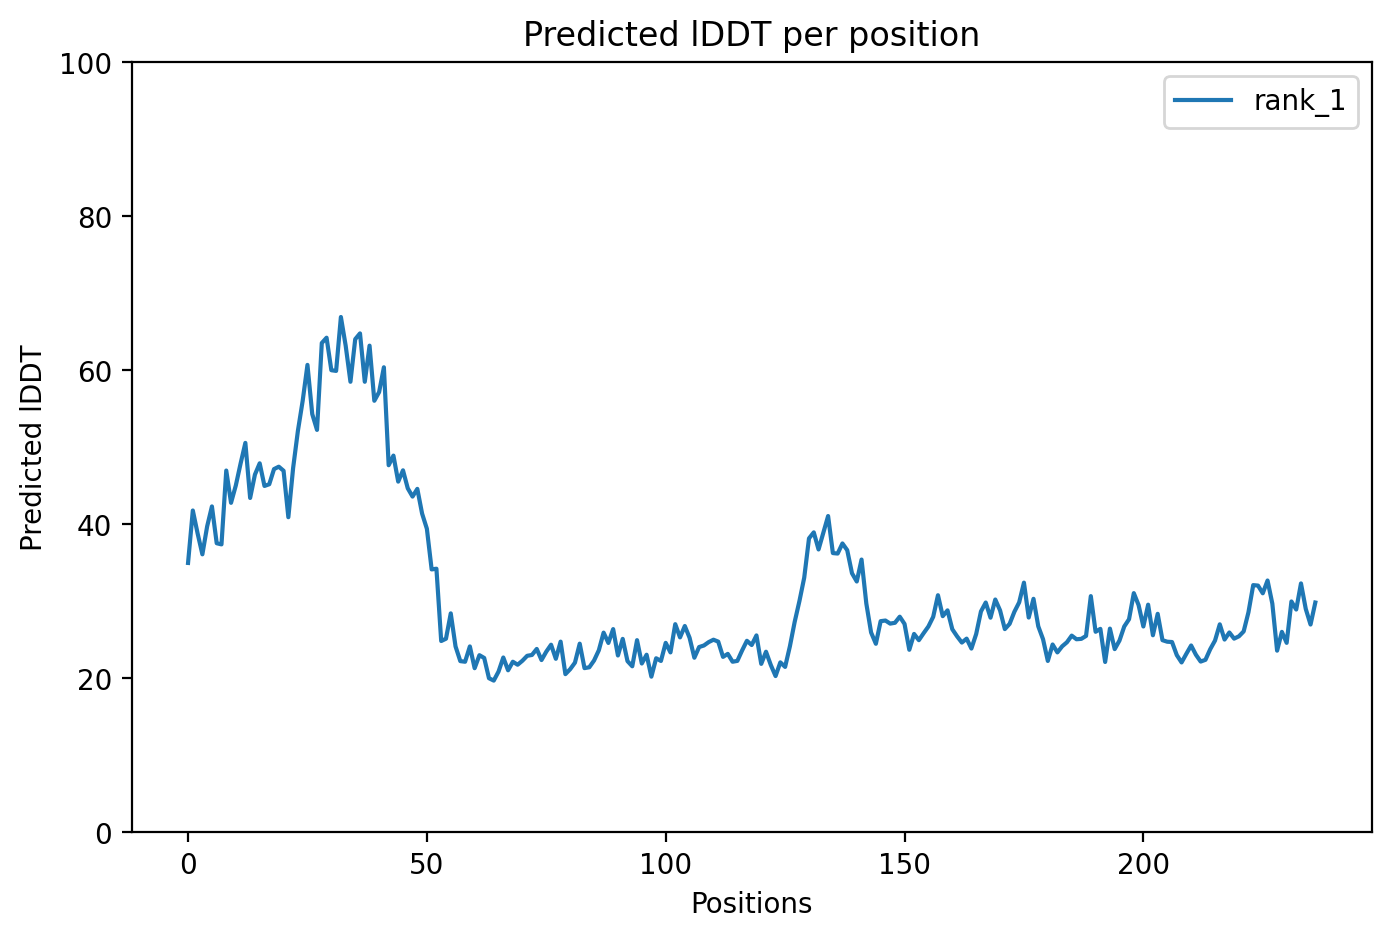

In [4]:
import os
import zipfile
from IPython.display import Image, display
import glob

# --- Configuration ---
result_dir = '/content/drive/MyDrive/result'
# -------------------

print(f"Searching for result files in: {result_dir}")

# Use glob to find all zip files in the result directory and its subdirectories
zip_files = glob.glob(os.path.join(result_dir, '**', '*.zip'), recursive=True)

if not zip_files:
    print("Error: No .zip files found in the result directory.")
    print("Please make sure the predictions have finished and the zip files are present.")
else:
    # Get the first zip file found
    zip_path = zip_files[0]
    print(f"\nFound result file: {zip_path}")

    plot_displayed = False
    # Open the zip file to find and display a plot
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Look for the pLDDT plot, which is a key quality metric
        for member in zip_ref.namelist():
            if "plddt.png" in member:
                print(f"Found plot file inside: {member}")

                # Extract the plot to a temporary directory
                extract_dir = "/tmp/colabfold_plots"
                os.makedirs(extract_dir, exist_ok=True)
                zip_ref.extract(member, path=extract_dir)
                image_path = os.path.join(extract_dir, member)

                # Display the image
                print("\nHere is an example of the pLDDT (model confidence) plot from one of your results:")
                print("It shows the confidence score (0-100) for each position in the protein.")
                display(Image(filename=image_path))
                plot_displayed = True
                break  # Stop after displaying the first plddt plot

    if not plot_displayed:
        print(f"Could not find a 'plddt.png' plot inside {os.path.basename(zip_path)}.")